In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob
from ipynb.fs.full.MyFunctions import xirr #Import 'xirr' function from another notebook




#path = Path("F:/Dowloads/investment/")
path = Path("C:/Users/Itai/Git/My_Investment_Analysis/My_Investment_Analysis/Investment_Raw_Data/") #Change to local directory on machine after downloading Investment_Raw_Data folder

filenames = path.glob('data*.xlsx') 

### Importing Data

In [124]:
df = pd.DataFrame() #main df
for f in filenames: #Append Excel filenames into one DataFrame
    df = df.append(pd.read_excel(f))
df = df.reset_index(drop=True)
df.head(2)

,תאריך,נייר/תנועה,מס' נייר/תנועה,פעולה,כמות,מחיר,זכות נטו,חובה נטו,עמלה,יתרה,אסמכתא
0,30 בנוב׳ 2014,"100 ת""א MTF",5109889,הפקדה,7028.0,144.65,0.0,0.0,0.0,0.0,995021
1,30 בנוב׳ 2014,S&P 500 MTF,5117478,הפקדה,14939.0,149.93,0.0,0.0,0.0,0.0,995022


In [125]:
months_df = pd.read_excel(path / 'month_translation.xlsx', header = None) #months df for translation
months_df.head(2)

,0,1
0,ינו,jan
1,פבר,feb


In [126]:
present_state = pd.read_excel(path / '25062019_snapshot.xlsx') #Present state of portfolio
present_state.head(2)

,שם נייר,מספר נייר,סימבול,מטבע,כמות נוכחית,שער,שווי נוכחי,רווח/הפסד יומי,שינוי מעלות,שינוי מעלות ב%,עלות,אחוז אחזקה
0,RU DEPOS.קסם,1145770,קסם.ס65,שקל חדש 000,259.0,6730.0,17430.7,44.03,7507.62,75.66,9923.08,3.06
1,פסג.תא נדלן,1148691,פסג.ס37,שקל חדש 000,3321.0,617.6,20510.5,-13.28,6507.57,46.47,14002.93,3.60


### Rename Coulumns

Translate Columns from Hebrew to English

In [127]:
old_cols = list (df.columns)
new_cols = ['date','stock_desc','stock_num','action_type','quantity','price','action_credit','action_cost','commission','balance','confirmation_num']
new_cols_dict = dict(zip(old_cols, new_cols))
df.rename(columns =new_cols_dict,inplace=True)
df.head(2)

,date,stock_desc,stock_num,action_type,quantity,price,action_credit,action_cost,commission,balance,confirmation_num
0,30 בנוב׳ 2014,"100 ת""א MTF",5109889,הפקדה,7028.0,144.65,0.0,0.0,0.0,0.0,995021
1,30 בנוב׳ 2014,S&P 500 MTF,5117478,הפקדה,14939.0,149.93,0.0,0.0,0.0,0.0,995022


### Data Cleaning & Casting

Cast 'date' column to date datatype

In [128]:
month_dict = dict(zip(months_df.iloc[:,0], months_df.iloc[:,1]))
df['date'] = df['date'].replace(month_dict, regex=True).replace('ב','' ,regex=True).str.replace(" ","")
df['date'] =  pd.to_datetime(df['date'], format='%d%b%Y')
df.head(2)

,date,stock_desc,stock_num,action_type,quantity,price,action_credit,action_cost,commission,balance,confirmation_num
0,2014-11-30,"100 ת""א MTF",5109889,הפקדה,7028.0,144.65,0.0,0.0,0.0,0.0,995021
1,2014-11-30,S&P 500 MTF,5117478,הפקדה,14939.0,149.93,0.0,0.0,0.0,0.0,995022


Clean extra white spaces in 'stock_desc' column

In [129]:
df["stock_desc"] = df.stock_desc.str.split().str.join(" ") 

### Visualise Action Types

In [130]:
val=df.action_type.value_counts()
val.index = val.index.map(lambda x: x[::-1]) #reverse text

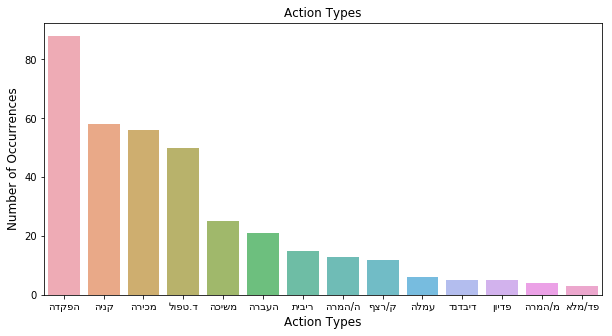

In [131]:
plt.figure(figsize=(10,5))
sns.barplot(val.index, val.values, alpha=0.8)
plt.title('Action Types')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Action Types', fontsize=12)
plt.show()

### Dropping Irrelevant Rows

Drop rows where 'action_type' is הפקדה and in 'stock_desc' contain the word 'מס'. They don't add any value

In [132]:
df=df[~((df['stock_desc'].str.contains('מס')) & (df['action_type']=='הפקדה'))]

More rows to delete

In [133]:
more_rows_to_delete=['משיכה','העברה','ה/המרה','מ/המרה'] 
df=df[~df['action_type'].isin(more_rows_to_delete)]
df.head(2)

,date,stock_desc,stock_num,action_type,quantity,price,action_credit,action_cost,commission,balance,confirmation_num
0,2014-11-30,"100 ת""א MTF",5109889,הפקדה,7028.0,144.65,0.0,0.0,0.0,0.0,995021
1,2014-11-30,S&P 500 MTF,5117478,הפקדה,14939.0,149.93,0.0,0.0,0.0,0.0,995022


In [134]:
df.shape

(214, 11)

### Updating Values For Some Rows

In [135]:
df.loc[df.action_type=='הפקדה','action_cost'] =(df.quantity * df.price)/100 #Securities I've already had in possession, held in a different account
df.head(2)

,date,stock_desc,stock_num,action_type,quantity,price,action_credit,action_cost,commission,balance,confirmation_num
0,2014-11-30,"100 ת""א MTF",5109889,הפקדה,7028.0,144.65,0.0,10166.0020,0.0,0.0,995021
1,2014-11-30,S&P 500 MTF,5117478,הפקדה,14939.0,149.93,0.0,22398.0427,0.0,0.0,995022


### Present State df

In [136]:
ps = present_state.loc[:,['שם נייר','מספר נייר','שווי נוכחי']] #leave only relevant columns
ps.columns = ['stock_desc','stock_num','value'] #translate columns names
ps['date'] = pd.Timestamp('25/06/2019') #add date column
ps['commission'] = 0
ps.head(2)

,stock_desc,stock_num,value,date,commission
0,RU DEPOS.קסם,1145770,17430.7,2019-06-25,0
1,פסג.תא נדלן,1148691,20510.5,2019-06-25,0


### Concatenation Between df

Concat main df to portfolio present state

In [137]:
df_concat = pd.concat([df,ps.rename(columns={'value':'action_credit'})],axis = 0)
df_concat.tail(2)

,action_cost,action_credit,action_type,balance,commission,confirmation_num,date,price,quantity,stock_desc,stock_num
12,NaN,21515.47,NaN,NaN,0.0,NaN,2019-06-25,NaN,NaN,קסם KTF 600 STOX,5125612
13,NaN,0.00,NaN,NaN,0.0,NaN,2019-06-25,NaN,NaN,מגן מס,9992983


In [138]:
#df_concat=df_concat[df_concat.stock_num==5119128]

Create cost df

In [139]:
df_cost = df_concat.loc[df_concat.action_cost!=0 ,['date','stock_num','action_cost','commission']] 
df_cost=df_cost.groupby(['date', 'stock_num'])['action_cost','commission'].agg('sum').reset_index()#deleting redundant rows (that sum up to zero)
df_cost['action_cost'] = (df_cost['action_cost'] + df_cost['commission']) *-1
df_cost = df_cost.loc[:,['date','action_cost']]
df_cost.head(2)

,date,action_cost
0,2014-11-30,-10166.0020
1,2014-11-30,-22398.0427


Create credit df

In [140]:
df_credit=df_concat.loc[df_concat.action_credit!=0 ,['date','stock_num','action_credit','commission']]
df_credit=df_credit.groupby(['date', 'stock_num'])['action_credit','commission'].agg('sum').reset_index()#deleting redundant rows (that sum up to zero)
df_credit['action_credit'] = df_credit['action_credit'] - df_credit['commission']
df_credit=df_credit.loc[:,['date','action_credit']]
df_credit.head(2)

,date,action_credit
0,2015-03-01,14.75
1,2015-03-01,33.22


Create df_xirr dataframe in a format that xirr() function acceptes

In [141]:
df_xirr = pd.concat([df_cost.rename(columns={'action_cost':'value'}),df_credit.rename(columns={'action_credit':'value'})], axis = 0).reset_index(drop=True)
df_xirr.head(2)

,date,value
0,2014-11-30,-10166.0020
1,2014-11-30,-22398.0427


In [142]:
df_xirr.head()
tuples_xirr = [tuple(row) for row in df_xirr.values]

In [143]:
xirr(tuples_xirr)*100

3.6904459193392825